# Deep Learning for Image Processing

[1](#1): Image, audio; all the same (15 points)

[2](#2): Denoising (25 points)

[3](#3): Auto-encoder (30 points)

[4](#4): Variational auto-encoder (30 points)

## Datasets

All the datasets must be contained in the `Datasets` folder at the same level of hierarchy as the notebook.
In this project we use MNIST, CelebA, audio data and noisy images.

## Packages

### NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [1]:
import IPython
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Module
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
from skimage.metrics import peak_signal_noise_ratio
import os
import torchvision
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF

In [2]:
# install prettytable and uncomment to use count_paramters function
from prettytable import PrettyTable 

In [3]:
# install livelossplot and uncomment below to plot losses live (while training) <- highly suggested
!pip install livelossplot
from livelossplot import PlotLosses

Set random seed

In [4]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Set device

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Create folder in which save models

In [6]:
os.makedirs('models', exist_ok=True)

In [7]:
!wget http://geometry.cs.ucl.ac.uk/mlvc/s/Datasets.zip
!unzip Datasets

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Utility functions

In [8]:
def plot_images(images, titles, texts):
    N_cols = len(images)
    N_rows = len(images[0])
    
    fig, axs = plt.subplots(N_rows, N_cols)
    
    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])
    
    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()


def count_parameters(model):
    # you can use this function to print number parameters per layer
    # install prettytable and uncomment import to use count_paramters function
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## 1. Image, audio; all the same (15 points)
<a name='1'></a>

[a)](#1a) Implement a filter to remove low temporal frequencies (`highpass_fft_filter_audio`) from the audio file `audio.npy`, provided under `Datasets/Filtering/`. Plot the input and output of your filter as line graphs. (**2 points**) Implement a version using FFT (`highpass_fft_filter_audio`) and a version using moving average (`highpass_normal_filter_audio`) (**2 points**), discuss which version, when and why is better (**1 point**).

[b)](#1b) Implement a filter to find vertical edges in an image. We provide a sample file `image.png` under
`Datasets/Filtering/` for testing. Apply your filter to this image and display the input and output of your filter. (**8 points**) Implement the filter without for loops (**2 points**).


** 1.a**
<a name='1a'></a>

Implement a filter to remove low temporal frequencies

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [9]:
def highpass_fft_filter_audio(audio):
    #solution
    
    audio_rate = 44e3   # The audio sample is assumed to have been acquired at 44Khz sampling rate
    dt = 1/audio_rate #this is the sample time derived from the audio rate
    total_time = len(input_audio)*dt #The total time is defined as the number of samples taken times the sample time

    #We use np.fft.fft() to filter frequencies, as we are not filtering the amplitudes but the frequency, we cannot 
    #filter the raw data
    audio_fft = np.fft.fft(audio)

    # The corresponding frequencies
    freq = np.array(np.fft.fftfreq(audio.size, d=dt))

    #Filtering the frequencies, creating a copy as we do not want to filter the frequencies of the original audio.
    filtered_frequency = audio_fft.copy()
    #7500 because identified from the graph as noisy data, upon plotting the frequencies
    threshold = 7500
    #setting all low frequencies below set threshold to zero as these are identified as noise
    filtered_frequency[np.abs(freq) < threshold] = 0 
    filtered_audio = np.fft.ifft(filtered_frequency)

    #end_solution

    
    
    return filtered_audio

In [10]:
def highpass_normal_filter_audio(audio):
    filtered_audio = None
    #solution

    filtered_audio = audio.copy() #Creating a copy so that original data is unaffected

    #Moving average formula = (1/N)* Sum j(0->N-1) (xi+xj)
    #We instead use np.convolve which uses a kernel which we have defined as a gaussian, and applies
    #a weight to each element we use to calulate the moving average, this way the current sample is given more importance.
    
    #Using N as 3 as we want a kernel that applies the moving average to one sample width sourrounding the current sample being convolved
    N = 3 # sweep size

    #Initialising the Gaussian
    gaussian = np.linspace(int(-N/2),int(N/2),N)
    #Finding the Gaussian distribution (normal distribution)
    mu = 0
    sig=1
    gaussian = np.exp(-0.5 * np.square(gaussian) / np.square(sig))
    gaussian = gaussian / np.sum(gaussian)
    
    #Finding the moving average by applying the defined gaussian and convolving it through the audio.
    #this also helps to Implement the filter without for loops
    moving_average = np.convolve(audio.copy(),gaussian,'same')
    
    #We remove the moving average from the audio as the average is likely noise and we would like to remove it.
    filtered_audio = audio.copy() - moving_average

    

    #end_solution

    
    
    return filtered_audio

In [11]:
audio_rate = 44e3   # The audio sample is assumed to have been acquired at 44Khz sampling rate

Load  audio from file

In [12]:
# load input_audio from input_audio_filename
input_audio_filename = "./Datasets/Filtering/audio.npy"
input_audio = np.load(input_audio_filename)
print(f"Audio array shape: {input_audio.shape}")

# The audio sample played at 44khz sampling rate. Basically a 1 second noise sample. 
IPython.display.Audio(input_audio, rate=audio_rate)

Audio array shape: (1000,)


Run filtering with input data 

In [13]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_fft_filter_audio(input_audio)

In [14]:
print("Original audio")
IPython.display.Audio(input_audio, rate=audio_rate)

Original audio


In [15]:
print("Filtered audio")
IPython.display.Audio(filtered_audio, rate=audio_rate)

Filtered audio


C:\Users\adamj\AppData\Roaming\Python\Python39\site-packages\IPython\lib\display.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


Plot the original audio and the filtered version

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


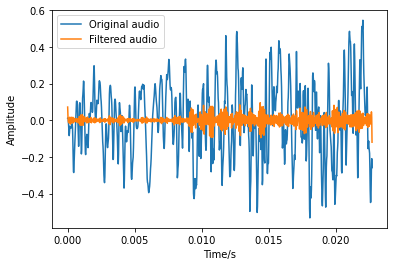

In [16]:
# plot input_audio and filtered_audio

#solution


dt = 1/audio_rate
total_time = len(input_audio)*dt
#Defining the x axis for our plots
time = np.arange(0,total_time,dt) #time vector


plt.plot(time, input_audio, label='Original audio')
plt.plot(time, filtered_audio, label='Filtered audio')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.show()


#end_solution


In [17]:
input_audio = np.load(input_audio_filename)
filtered_audio = highpass_normal_filter_audio(input_audio)

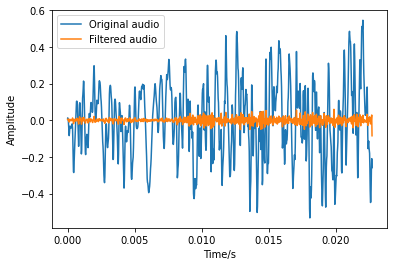

In [18]:
# plot input_audio and filtered_audio

#solution

dt = 1/audio_rate
total_time = len(input_audio)*dt
#Defining the x axis for our plots
time = np.arange(0,total_time,dt) #time vector

plt.plot(time, input_audio, label='Original audio')
plt.plot(time, filtered_audio, label='Filtered audio')
plt.xlabel('Time/s')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.show()



#end_solution


Response:
In a moving average normal filter, the produced signal removes noise regardless of if it is a low pass filter or high pass filter. The quality of the FFT filter is however better for a particular operation as it garuntees to filter a particular frequency. This however is not a general solution, compared with the moving average filter, which works as is without modifications in more situations.

** 1.b**
<a name='1b'></a>

Implement a filter to find vertical edges in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def detect_vertical_edges(image):
    #solution
    
    # Using a Vertical Sobel Edge Detector, for which the filter is defined as follows:
    edge_filter = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    
    #Initialising the filtered image of the same shape as the input
    filtered_image_rgb = np.ndarray((image.shape))
    #Defining a 1D filtered image as edges found in each dimension will be found and combined.
    filtered_image = np.ndarray((image.shape[0],image.shape[1]))
    
    #Extracting essential dimensions that will be used for required convolution.
    w,h,d = image.shape
    iw, ih, id = image.shape
    fw, fh = edge_filter.shape
    
    # Adding padding to the image so that the filtered image and the new image are the same size after convolution
    pad_width=((fw//2,fw//2),(fh//2,fh//2),(0,0))
    # Finding the mean that will be used for padding the image
    mean = np.average(image)
    #Applying the padding:
    padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=mean)

    
    #Looping trough each pixel in the padded image and performing edge detection around that pixel to check if it is an edge point.
    for dim in range(id):
        for row in range(iw):
            for col in range(ih):
                # Applying a filter around the current image pixel
                filtered_image_rgb[row, col, dim] = np.average(edge_filter*padded_image[row:row+3,col:col+3,dim])

    #Combining the edges found in each dimension of the input image to show overall edges in the image.
    for row in range(w):
        for col in range(h):
            filtered_image[row, col] = np.average(filtered_image_rgb[row, col])/255


    #end_solution

    return filtered_image

In [20]:
input_image_filename = "./Datasets/Filtering/image.png"

Run filter over the input image

In [21]:
input_image = np.asarray(PIL.Image.open(input_image_filename).convert('RGB'))
filtered_image = detect_vertical_edges(input_image)

Display the original image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

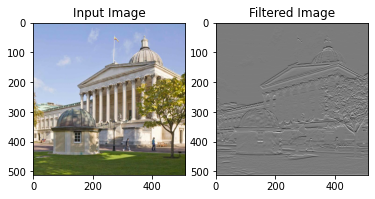

In [22]:
# display input_image and filtered_image here

#solution

f, imgs = plt.subplots(1,2)
imgs[0].imshow(input_image)
imgs[0].set_title('Input Image')
imgs[1].imshow(filtered_image,cmap='gray')
imgs[1].set_title('Filtered Image')
plt.show()

#end_solution



## 2. Denoising (25 points)
<a name='2'></a>

[a)](#2a) Implement `denoiseGauss(image)` to denoise the image noisy `image.png` under `Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#2b) Implement a pyramidal encoder-decoder to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `Datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The encoder and decoder must have at least 3 layers each. Please use ReLU non-linearities after each layer (**15 points**).
Please train for no more than 400 epochs.

[c)](#2c) Write a markdown block in your notebook, comparing the Gaussian and encoder-decoder denoising
methods. Include example output images from each method and discuss which method performs better and where. You should write no more than half a page. (**5 points**)

** 2.a**
<a name='2a'></a>

Implement the function to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [23]:
def gkern(l=5, sig=1.):
    
    #solution

    #Initialising the Gaussian
    gaussian = np.linspace(int(-l/2),int(l/2),l)
    #Finding the Gaussian distribution (normal distribution) of an array of size l
    mu = 0
    gaussian = np.exp(-0.5 * np.square(gaussian) / np.square(sig))
    gaussian = gaussian / np.sum(gaussian)
    
    #Finds the Kernel that is the product of the gaussian over both dimensions of the image
    out_kernel = np.outer(gaussian, gaussian)
    # Normalising the Kernel
    max = np.max(out_kernel)
    out_kernel = out_kernel / max

    #end_solution

    
    return out_kernel

def denoise_gauss(image):
    
    #solution

    #Defining the filter to use for denoising
    filter = np.array(gkern(l=5, sig=1.0))

    #Extracting essential dimensions that will be used for required convolution.
    iw, ih, id = image.shape
    fw, fh = filter.shape
    
    #Initialising the denoised image
    denoised_image = np.zeros(image.shape)


    # Adding padding to the image so that the filtered image and the new image are the same size
    pad_width=((fw//2,fw//2),(fh//2,fh//2),(0,0))
    #adding the mean of the data as padding
    mean = np.mean(image)
    #Applying the padding:
    padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=mean)


    #Performing convolution over all channels of the image (RGB)
    for dim in range(id):
        for row in range(iw):
            for col in range(ih):
                #The convolution performed, starting at the top left cell of the padded image:
                denoised_image[row, col, dim] = np.sum(np.multiply(padded_image[row:(row + fw), col:(col + fh), dim],filter))
                #Making sure that the convolution sums to 1
                denoised_image[row, col, dim] = int((denoised_image[row, col, dim]/ np.sum(filter)))
    #Converting to uint so that it can be interpretted as an image
    denoised_image = denoised_image.astype(np.uint8)


    #end_solution

    
    return denoised_image

Load input image from file

In [24]:
noisy_image_filename = "./Datasets/Filtering/noisy_image.png"

Filter the input image

In [25]:
noisy_image = np.asarray(PIL.Image.open(noisy_image_filename))
denoised_image = denoise_gauss(noisy_image)

Display the input image and its filtered version side by side

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

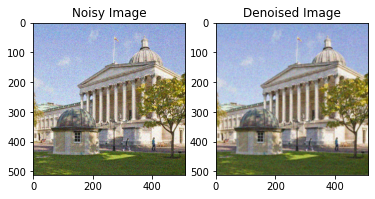

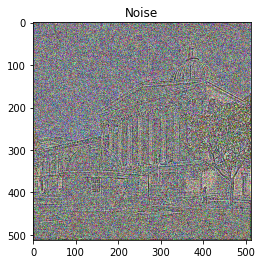

In [26]:
# display input_image and denoised_image here
#solution

f, imgs = plt.subplots(1,2)
imgs[0].set_title('Noisy Image')
imgs[0].imshow(Image.fromarray(noisy_image))
imgs[1].set_title('Denoised Image')
imgs[1].imshow(Image.fromarray(denoised_image))
plt.show()

##Ploting this to show what is happening
#high frequencies are removed and this includes the edges, which can be seen in the plot for the noise
plt.imshow(Image.fromarray(denoised_image-noisy_image))
plt.title('Noise')
plt.show()

#end_solution


** 2.b**
<a name='2b'></a>

Implement dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [27]:
class DenoisingDB(Dataset):
    
    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()
        
        #solution


        self.noisy_imgs = []
        self.cleaned_imgs = []
        #Looping through each filename that exists within the input images path
        for input_image_filename in os.listdir(input_imgs_path):
            #The full file path for current image:
            input_image_filename = os.path.join(input_imgs_path, input_image_filename)
            #Reading the image from the filepath.
            image = np.asarray(PIL.Image.open(input_image_filename))
            #Appending the array that contains all the images found in the searched folder
            self.noisy_imgs.append(image)

        #Doing the same in the folder for cleaned images:
        for input_image_filename in os.listdir(cleaned_imgs_path):
            input_image_filename = os.path.join(cleaned_imgs_path, input_image_filename)
            image = np.asarray(PIL.Image.open(input_image_filename))
            self.cleaned_imgs.append(image)
        
        #Using image patches of size 128×128 as asked in the 
        #Not using random crop as this will apply different crop on both the target and test images.
        #We cannot run inference on different sized images so therefore standardising all images.
        #Also applying a transform to convert all images to tensor to compute the CNN using pytorch.
        self.transform=transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(128)])

        #end_solution


    def __len__(self):
        
        #solution

        length = len(self.noisy_imgs)

        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution
        input_image = self.transform(self.noisy_imgs[idx])
        target_image = self.transform(self.cleaned_imgs[idx])
        #end_solution

        
        return (input_image, target_image)

Implement the Encoder network: 5 levels and double the number of internal activations when reducing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
class Encoder(Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        #solution

        kernel_size = 3
        stride = 2
        padding = 1
        
        #ENCODER:
        self.encode = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16,32,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,64,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )


        #end_solution


    def forward(self,high_res_image):
        
        #solution
        
        low_res_image = self.encode(high_res_image)
        #end_solution

        
        return low_res_image

Implement the Decoder network: 5 levels and half the number of internal activations when increasing the spatial resolution. Please use ReLU non-linearities.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [29]:
class Decoder(Module):

    def __init__(self):
        super(Decoder, self).__init__()
        
        #solution

        kernel_size = 3
        stride = 2
        padding = 1
        
        #DECODER:
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_size,stride=stride,padding=padding,output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=kernel_size,stride=stride,padding=padding,output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=kernel_size,stride=stride,padding=padding,output_padding=1),
            nn.Sigmoid()
        )


        #end_solution


    def forward(self, low_res_image):
        
        #solution
        
        denoised_image = self.decode(low_res_image)

        #end_solution

        
        return denoised_image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
def loss_function(input,target):
    
    #solution
    
    loss = nn.MSELoss()(input,target)

    #end_solution

    
    return loss

Paths input data

In [31]:
input_imgs_path = "./Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "./Datasets/Denoising/target_clean_images"

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

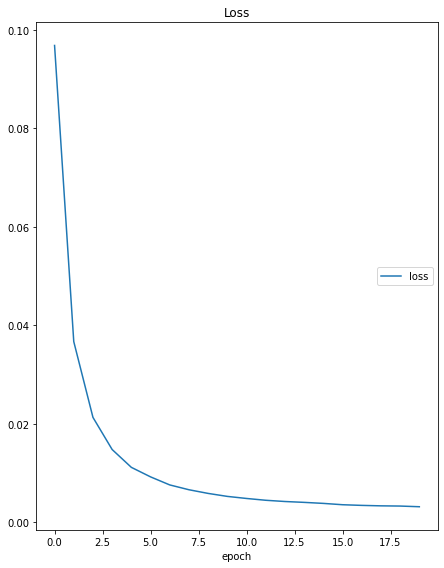

Loss
	loss             	 (min:    0.003, max:    0.097, cur:    0.003)


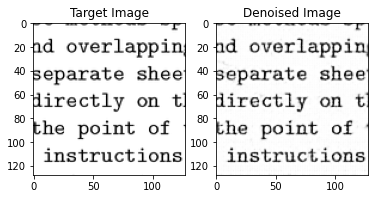

In [32]:
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

#solution

# number of epochs
n_epoch = 20
# batch size
batch_size = 2
# learning rate
learning_rate = 0.001

#Using this to plot loss curves for each epoch live while training
liveloss = PlotLosses()

#Loading the image data using trainloader
trainloader = DataLoader(docs_dataset, batch_size=batch_size, shuffle=True)

#USing the Adam Optimizer for the CNN
optimizer = optim.Adam([{'params':encoder.parameters()},{'params':decoder.parameters()}],lr=learning_rate)


for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input, target = data

        # initializing gradients
        optimizer.zero_grad()
        
        ##ENCODING:
        low_res_image=encoder(input.to(device))  #Setting image to device to allow the encoder to use input as torch.cuda
        ##DECODING:
        denoised_image=decoder(low_res_image)
        
        #LOSS:
        loss = loss_function(denoised_image,target.to(device))
        
        #BACKPROPOGATION:
        loss.backward()
        optimizer.step()
        
        #Finding total epoch loss:
        epoch_loss += loss.item()/trainloader.__len__()
        
    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    #Plotting functions
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    # Plotting target and denoised image after each epoch to visualise performance.
    f, imgs = plt.subplots(1,2)
    imgs[0].set_title('Target Image')
    imgs[0].imshow(np.squeeze(((target.cpu().detach().numpy()[0])*255).astype(np.uint8)),cmap="gray")
    imgs[1].set_title('Denoised Image')
    imgs[1].imshow(np.squeeze(((denoised_image.cpu().detach().numpy()[0])*255).astype(np.uint8)),cmap="gray")
    plt.show()




#end_solution



Save the model (needed for marking)

In [33]:
torch.save({'encoder':encoder, 'decoder':decoder}, 'models/ex2b.pth')

Load trained model

# NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [34]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Plot 5 input images and their relative denoised images side by side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

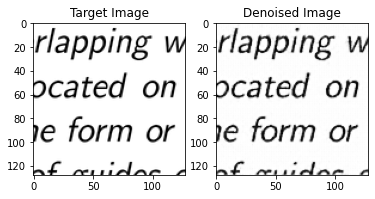

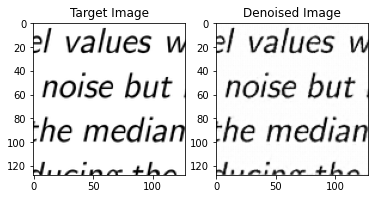

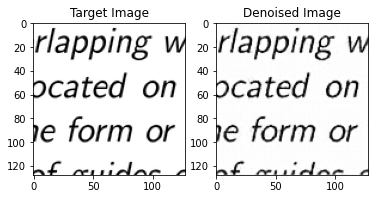

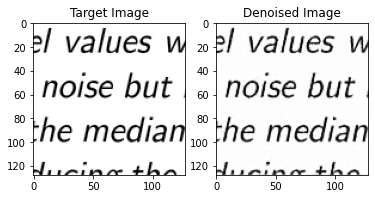

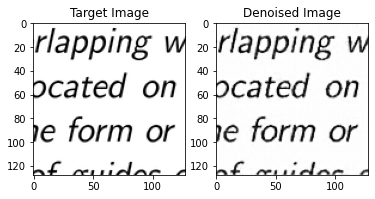

In [35]:
#solution
docs_dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

for idx in range(5):

    input_image, target_image = docs_dataset.__getitem__(idx)
    
    #Unsqueezing images to create a 4D image in the shape: batch_size,channels,height,width
    input_image = torch.unsqueeze(input_image, dim=0)
    target_image = torch.unsqueeze(target_image, dim=0)
    
    #Encoding:
    low_res_image = encoder(input_image.to(device))
    #Decoding:
    denoised_image = decoder(low_res_image)

    #Squeezing images as channels are equal to 1, which do not represent anything while plotting the image.
    #Extracting the first element of the images as batch size is equal to 1.
    target_image = np.squeeze(((target_image.cpu().detach().numpy()[0])*255).astype(np.uint8))
    denoised_image = np.squeeze(((denoised_image.cpu().detach().numpy()[0])*255).astype(np.uint8))

    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(target_image,cmap="gray")
    imgs[0].set_title('Target Image')
    imgs[1].imshow(denoised_image,cmap="gray")
    imgs[1].set_title('Denoised Image')
    plt.show()

#end_solution


** 2.c**
<a name='2c'></a>

Load trained model

In [36]:
state_dict = torch.load('models/ex2b.pth')
encoder = state_dict['encoder'].to(device)
decoder = state_dict['decoder'].to(device)

Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [37]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [docs_dataset[i][0].to(device) for i in range(5)]
targets = [docs_dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#solution
for idx in range(len(images)):

    #Unsqueezing images to create a 4D image in the shape: batch_size,channels,height,width
    input_image = torch.unsqueeze(images[idx], dim=0)
    target_image = torch.unsqueeze(targets[idx], dim=0)
    
    #Encoding:
    low_res_image = encoder(input_image.to(device))
    #Decoding:
    denoised_image = decoder(low_res_image)
    #Squeezing output image:
    denoised_image = torch.squeeze(denoised_image, dim=0)

    #Extracting the first element of the images as batch size is equal to 1.
    target_image = ((target_image.cpu().detach().numpy()[0])*255).astype(np.uint8)
    denoised_image = ((denoised_image.cpu().detach().numpy()[0])*255).astype(np.uint8)
    #Appending to results array the AE solution for denoising:
    images_ae.append(denoised_image)
    #Simply finding the denoised image using the gaussian solution by calling denoise_gauss function:
    #Appending to results array the Gaussian solution for denoising:
    images_gauss.append(denoise_gauss(target_image))
    
images_gauss = np.squeeze(images_gauss)

#end_solution



Plot images and PSNR

In [38]:
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

C:\Users\adamj\AppData\Local\Temp/ipykernel_6912/3196966080.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
C:\Users\adamj\AppData\Local\Temp/ipykernel_6912/3196966080.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])


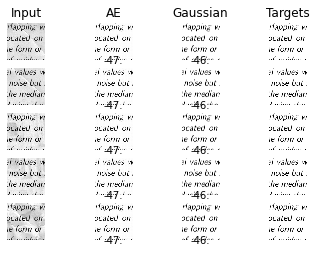

In [39]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images(img, titles, texts)
plt.show()

Comment on the results obtained from the plot above.

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

As seen above, the Gaussian denoising model does not perform as good as the encoder-decoder denoising model but still does a decent job.

The advantage here is that we do not need training images for the Gaussian denoising, and do not need a separate model to denoise different types of images, as the gaussian method is generic and can be applied to any image.

The encoder-decoder method, however, produces much clearer images and we can add further convolution layers to learn even more complex detail about our image and produce the output that considers these complexities.

## 3. Auto-encoder (30 points)
<a name='3'></a>

[a)](#3a) Implement a convolutional auto-encoder (AE). The loss between in and output should be **L2**. You can make use of all the convolution, pooling, back-propagation and build-in functionality of `Pytorch` here. (**15 points**)
$$
||I −dec(enc(I))||^2_2
$$

[b)](#3b) Test it on the MNIST (`Datasets/MNIST/`) dataset by encoding and decoding their first 5 samples. Compile a document showing, for each sample, the input and the AE reconstruction, side-by-side. (**5 points**)
Please train for no more than 100 epochs.

[c)](#3c) Implement an auto-encoder (AE) and train it on CelebA. Choose the loss you deem more appropriate. Output 5 images from the AE you trained.  (**5 points**)

Please train it for no longer than 400 epochs.


[d)](#3d) Discuss your design choices for Q3a and Q3c. Are the models different? Why? Discuss in no more than 15 sentences. If needed add plots and a demo. (**5 points**)



** 3.a**
<a name='3a'></a>

Implement a convolutional auto-encoder

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [40]:
class AutoEncoder(Module):
    
    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size = channel_size
        
        #solution

        self.encode = nn.Sequential(
            #ENCODING
            nn.Conv2d(self.channel_size,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #IMPLEMENTING BOTTLENECK
            nn.Flatten(start_dim=1),
            nn.Linear(128*4*4,128),
            nn.ReLU(True),
            nn.Linear(128,self.bottleneck_size)

        )


        self.decode = nn.Sequential(
            #PROCESSING BOTTLENECK
            nn.Linear(self.bottleneck_size,128),
            nn.ReLU(True),
            nn.Linear(128,128*4*4),
            nn.ReLU(True),
            nn.Unflatten(dim=1,unflattened_size=(128, 4, 4)),
            #DECODING
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,self.channel_size,kernel_size=3,stride=2,padding=1,output_padding=1), #Output channel size must be equal to input channel size
            nn.Sigmoid()
        )

        


        #end_solution

    
    def encoder(self,image):
        
        #solution

        code = self.encode(image)

        #end_solution

        
        return code
    
    def decoder(self,code):
        
        #solution

        decoded_image = self.decode(code)

        #end_solution

        
        return decoded_image
    
    def forward(self,image):
        
        #solution

        image = self.encoder(image)
        decoded_image = self.decoder(image)

        #end_solution

        
        return decoded_image

** 3.b**
<a name='3b'></a>

Implement the dataset class to load MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [41]:
class MNIST(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution

        self.mnist_dataset = []
        for input_image_filename in os.listdir(dataset_path):
            input_image_filename = os.path.join(dataset_path, input_image_filename)
            image = np.asarray(PIL.Image.open(input_image_filename))
            self.mnist_dataset.append(np.array(image))

        self.transform=transforms.Compose([transforms.ToTensor()])

        #end_solution


    def __len__(self):
        
        #solution

        length = len(self.mnist_dataset)

        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution

        image = self.transform(self.mnist_dataset[idx])

        #end_solution

        
        return image

Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [42]:
def reconstruction_loss(input,target):
    
    #solution

    recon_loss = nn.MSELoss()(input,target)

    #end_solution

    
    return recon_loss

Create dataloaders for training and validation

In [43]:
mnist_train_data_path = "./Datasets/MNIST/train/"
mnist_train_dataset = MNIST(mnist_train_data_path)

mnist_validation_data_path = "./Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)

Train the AE on MNIST

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

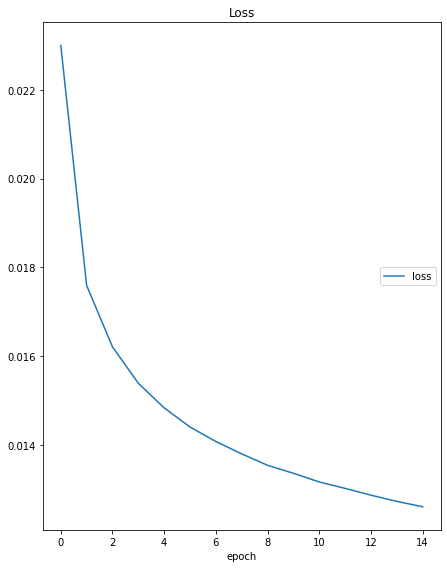

Loss
	loss             	 (min:    0.013, max:    0.023, cur:    0.013)


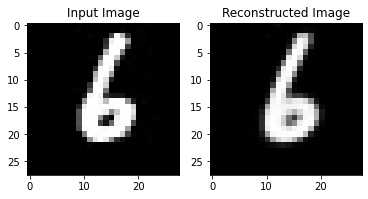

Total Loss:  0.22052954148435822


In [157]:

mnist_autoencoder = None # your model (assign below)

#solution
mnist_autoencoder = AutoEncoder(bottleneck_size=8,channel_size=1).to(device)


# number of epochs
n_epoch = 15
# batch size
batch_size = 4
#learning_rate
learning_rate = 0.001

#Using this to plot loss curves for each epoch live while training
liveloss = PlotLosses()

#Loading the image data using trainloader
trainloader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

#USing the Adam Optimizer for the CNN
optimizer = optim.Adam(mnist_autoencoder.parameters(),lr=learning_rate)

total_loss = 0.0

input = None
output = None

for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input = data.to(device)
        
        # initializing gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = mnist_autoencoder(input)
        
        #Finding loss
        loss = reconstruction_loss(output,input)
        
        # Backpropogation
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()/trainloader.__len__()
        total_loss += loss.item()/trainloader.__len__()
    
    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    #Plotting functions:
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    #Plotting the first image in the last batch in each epoch to visualise performance for input vs output
    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(np.squeeze(((input.cpu().detach().numpy()[0])*255).astype(np.uint8)),cmap="gray")
    imgs[0].set_title('Input Image')
    imgs[1].imshow(np.squeeze(((output.cpu().detach().numpy()[0])*255).astype(np.uint8)),cmap="gray")
    imgs[1].set_title('Reconstructed Image')
    plt.show()
    
print("Total Loss: ", total_loss)

#end_solution


Save trained model (needed for marking)

In [158]:
torch.save(mnist_autoencoder, 'models/ex3.pth')

Load trained model

# NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [44]:
mnist_autoencoder = torch.load('models/ex3.pth')

Showing, for 5 samples in the validation set, the input and the AE reconstruction, side-by-side.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

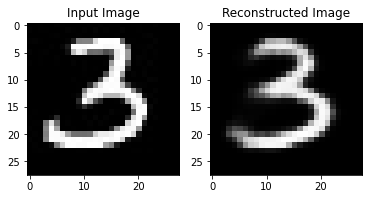

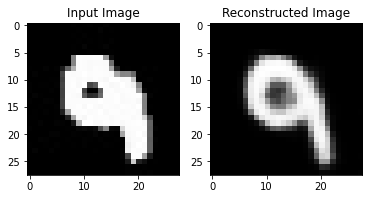

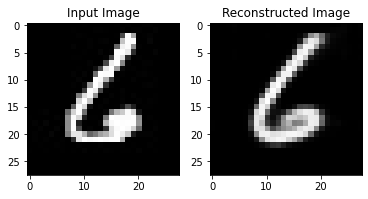

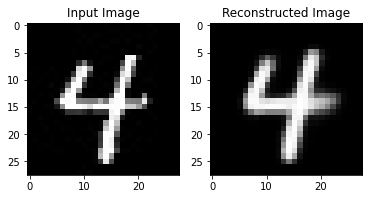

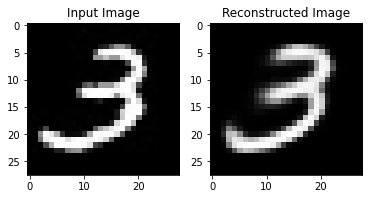

In [46]:
indices = np.random.choice(range(len(mnist_validation_dataset)), 5, replace=False)
mnist_random_images = [mnist_validation_dataset[idx] for idx in indices]


#solution

for mnist_random_image in mnist_random_images:

    mnist_random_image = torch.unsqueeze(mnist_random_image, dim=0)
    
    reconstructed_image = mnist_autoencoder(mnist_random_image.to(device))

    target_image = np.squeeze(((mnist_random_image.cpu().detach().numpy()[0])*255).astype(np.uint8))
    reconstructed_image = np.squeeze(((reconstructed_image.cpu().detach().numpy()[0])*255).astype(np.uint8))

    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(target_image,cmap="gray")
    imgs[0].set_title('Input Image')
    imgs[1].imshow(reconstructed_image,cmap="gray")
    imgs[1].set_title('Reconstructed Image')
    plt.show()

#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

** 3.c**
<a name='3c'></a>

Write your AE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [47]:
class CebelAAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        
        #solution
        
        self.encode = nn.Sequential(
            #ENCODING
            nn.Conv2d(self.channel_size,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,1024,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            #IMPLEMENTING BOTTLENECK
            nn.Conv2d(1024,self.bottleneck_size,kernel_size=(6,6)),
            nn.BatchNorm2d(self.bottleneck_size),
            nn.ReLU(True),
            nn.Flatten(start_dim=1)
        )
        
        
        self.decode = nn.Sequential(
            #PROCESSING BOTTLENECK
            nn.Unflatten(dim=1,unflattened_size=(self.bottleneck_size,1,1)),
            nn.ConvTranspose2d(self.bottleneck_size,1024,kernel_size=(6,6)),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            #DECODING
            nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(512,256,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,self.channel_size,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )

        #end_solution

    
    def encoder(self,image):
        
        #solution

        code = self.encode(image)

        #end_solution

        
        return code
        
    def decoder(self,code):
        #solution
        

        decoded_image = self.decode(code)


        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution

        image = self.encoder(image)
        decoded_image = self.decoder(image)


        #end_solution

        
        return decoded_image



Implete CelebA dataset class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [48]:
class CelebA(Dataset):
    
    def __init__(self, dataset_path):
        
        #solution

        self.celeba_dataset = []
        for input_image_filename in os.listdir(dataset_path):
            input_image_filename = os.path.join(dataset_path, input_image_filename)
            image = np.asarray(PIL.Image.open(input_image_filename))
            self.celeba_dataset.append(np.array(image))

        self.transform=transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(178)])


        #end_solution


    def __len__(self):
        
        #solution


        length = len(self.celeba_dataset)


        #end_solution

        
        return length

    def __getitem__(self, idx):
        
        #solution


        image = self.transform(self.celeba_dataset[idx])


        #end_solution

        
        return image


Create train and validation data loaders

In [49]:
celeba_train_data_path = "./Datasets/CelebA/train_subset/"
celeba_train_dataset = CelebA(celeba_train_data_path)

celeba_validation_data_path = "./Datasets/CelebA/val_subset/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)

Write your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [50]:
def reconstruction_loss(input,target):
    
    #solution

    recon_loss = nn.MSELoss()(input,target)

    #end_solution

    
    return recon_loss


Train AE on CelebA

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

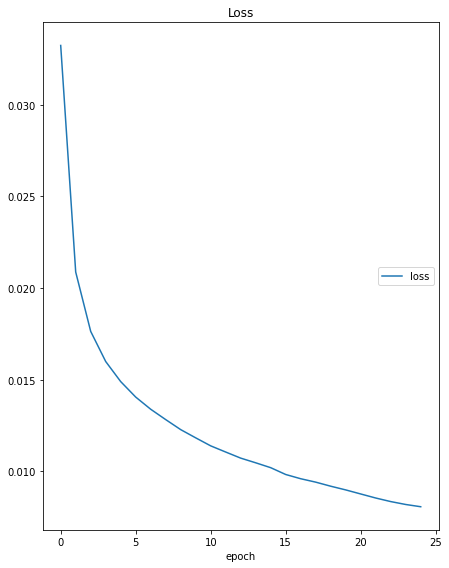

Loss
	loss             	 (min:    0.008, max:    0.033, cur:    0.008)


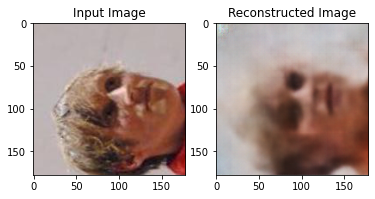

Total Loss:  0.3098582252122433


In [37]:

celeba_ae = None # create the AE and assign it to this

#solution
celeba_ae = CebelAAE(bottleneck_size=1024,channel_size=3).to(device)
#Change bottleneck size and implement it

# number of epochs
n_epoch = 25
# batch size
#using smaller batch size, will have better quality with smaller network required.
batch_size = 8 #power of 2 #If I choose too high, it would not run.
#learning_rate
learning_rate = 0.00005

#Using this to plot loss curves for each epoch live while training
liveloss = PlotLosses()

#Loading the image data using trainloader
trainloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)

#Using the Adam optimizer for the CNN
optimizer = optim.Adam(celeba_ae.parameters(),lr=learning_rate)
total_loss = 0.0
input = None
output = None
for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input = data.to(device)
        
        # initializing gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = celeba_ae(input)
        
        #Calculating loss
        loss = reconstruction_loss(output,input)
        
        # Backpropogation
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()/trainloader.__len__()
        total_loss += loss.item()/trainloader.__len__()

    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    #Plotting functions:
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    #Plotting the first image in the last batch in each epoch to visualise performance for input vs output
    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(((input.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    imgs[0].set_title('Input Image')
    imgs[1].imshow(((output.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    imgs[1].set_title('Reconstructed Image')
    plt.show()

print("Total Loss: ", total_loss)

#end_solution





In [38]:
torch.save(celeba_ae, 'models/ex_3_ae.pth')

# NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [51]:
celeba_ae = torch.load("models/ex_3_ae.pth")

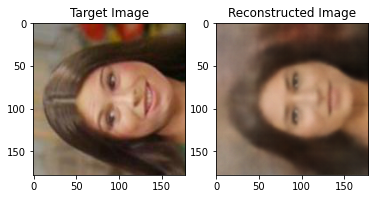

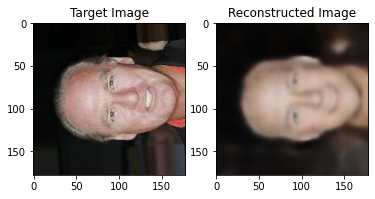

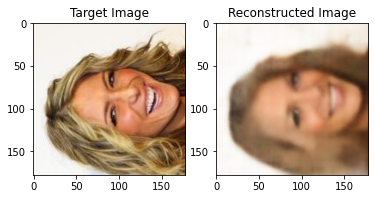

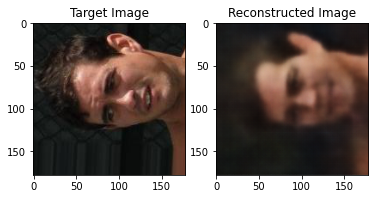

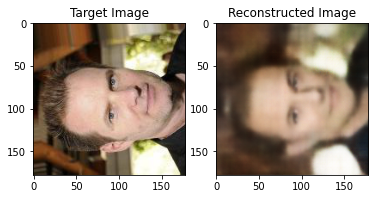

In [52]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]


#solution


for celeba_random_image in celeba_random_images:

    input_image = torch.unsqueeze(celeba_random_image, dim=0)

    celeba_ae.eval()
    output = celeba_ae(input_image.to(device))

    target_image = ((celeba_random_image.cpu().detach().numpy().T)*255).astype(np.uint8)
    reconstructed_image = ((output.cpu().detach().numpy()[0].T)*255).astype(np.uint8)

    f, imgs = plt.subplots(1,2)
    imgs[0].set_title('Target Image')
    imgs[0].imshow(target_image)
    imgs[1].set_title('Reconstructed Image')
    imgs[1].imshow(reconstructed_image)
    plt.show()



#end_solution


** 3.d**
<a name='3d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 


The complexity of the image determines the size of the bottleneck as more complex images may need more dominant features for reconstruction.

The mnist data may not need as many layers for convolution to reconstruct the image, as the data has a small variation with only a few classes; Whereas human faces have vast variation from person to person and need more features to be learned.

We also have to consider that for  3c, have a changing background and the architecture needs to learn to ignore the background.

The image size affects the consideration for how many layers to use as more layers reduce the size of the features being passed to the next layer based on the stride used, and if we use too many layers for a smaller image, we may end up losing the image through its journey to the bottleneck.

We also use only one input and output channel in 3a as the images are greyscaled, whereas in 3c, the images are RGB and therefore we have 3 input and output channels.

We can also notice that the image in 3a does a very good job with a bottleneck of just 8 features but the performance cannot be matched in Q3c even when using 1024 features for the bottleneck.

It can also be seen in the live loss plots while training both models, that we required fewer epochs to converge to our solution for Q3a as the model required to learn fewer weights.

We also use much lesser convolutional output channels at each layer in Q3c. This allows us to train the model faster, as it has fewer weights to learn. The model also takes up lesser memory and can be trained on a much bigger batch size, which allows for faster training if required.

In Q3c we use a much smaller learning rate as we have a much bigger network that is more prone to local minima, and therefore we need a smaller learning rate to learn more optimal weights, however, this makes training very slow.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

## 4. Variational auto-encoder (30 points)
<a name='4'></a>

[a)](#4a) Implement a Variational Auto-Encoder (VAE). (**10 points**)

[b)](#4b) Train and test it on the CelebA dataset by **generating 5 samples**. (**10 points**)

Please train it for no longer than 400 epochs.


[c)](#4c) Compare samples from the VAE to the samples of the AE (Q3c), by **generating 10 samples** and explain in one sentence what is the difference. (**5 points**)

[d)](#4d) Explain the main differences between Adam and SGD (**1 points**). Discuss which are the terms used by Adam and what role they play (**1 points**). Prepare a demo to show the difference between training a network with ADAM vs SGD. Show the loss curves, discuss what are the differences and why (**3 points**). (total 5)


** 4.a**
<a name='4a'></a>

Create the VAE class

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [53]:
class VAE(Module):

    def __init__(self, bottleneck_size, channel_size=1):
        super().__init__()
        self.bottleneck_size = bottleneck_size
        self.channel_size    = channel_size
        
        
        #solution

        #latent space is distributed like a normal distribution
        
        # mu and standard deviation are latent codes that are generated using the encoder
        # We want the images that are close to each other in the real space to end up close
        # to each other in the latent space, and therefore we use normal distribution


        # Using LeakyReLU as the VAE has problems with gradient decent. 
        self.encode = nn.Sequential(
            #ENCODING
            nn.Conv2d(self.channel_size,64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256,512,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512,1024,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            #IMPLEMENTING BOTTLENECK
            nn.Conv2d(1024,2048,kernel_size=(6,6)),
            nn.BatchNorm2d(2048),
            nn.ReLU(True),
            nn.Flatten(start_dim=1), #We start at dim = 1 as we do not want to flatten each image in the batch
        )

        #the bottleneck_size are the latent space dimensions that tells us the number of dimensions we need to concider.
        self.mu = nn.Linear(2048, self.bottleneck_size)
        self.std = nn.Linear(2048, self.bottleneck_size)
        
        self.decode = nn.Sequential(
            #PROCESSING BOTTLENECK
            nn.Linear(self.bottleneck_size, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024*6*6),
            nn.Unflatten(dim=1,unflattened_size=(1024,6,6)),
            #DECODING
            nn.ConvTranspose2d(1024,512,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.ConvTranspose2d(512,256,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1,inplace=True),
            nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1,inplace=True),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1,inplace=True),
            nn.ConvTranspose2d(64,self.channel_size,kernel_size=3,stride=2,padding=1,output_padding=1),
            nn.Sigmoid()
        )
        #end_solution

    
    def encoder(self,image):
        
        #solution

        code = self.encode(image)
        mu = self.mu(code)
        std = torch.exp(0.5*self.std(code))

        #end_solution

        
        return mu, std
    
    def reparametrization_trick(self,mu,std):
        
        #solution
        
        #Allows gradient decent despite random sampling
        #z = (sample*std) + mu
        #sample ~ N(0,I) sampling from normal distribution
        sample = torch.randn_like(std) #Returns tensor from with mean 0 and variance 1 of same size as std.
        #Normal distribution sample with mean and standard deviation of decoded image.
        z = (sample*std) + mu

        #end_solution

        
        return z
    
    def decoder(self,code):
        #solution
        
        decoded_image = self.decode(code)

        #end_solution

        
        return decoded_image
    
    def forward(self, image):
        
        #solution


        #encoding input as distribution over latent space
        mu, std = self.encoder(image)
        #sampling from latent representation a point, z, from encoded distribution
        z = self.reparametrization_trick(mu,std)
        #decoding the sampled point
        decoded_image = self.decoder(z)
        
        
        #end_solution

        
        return decoded_image, mu, std

** 4.b**
<a name='4b'></a>

Implement your losses here

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [54]:
def reconstruction_loss(input,target):
    
    #solution

    #The reconstruction loss makes the system more efficient

    recon_loss = nn.MSELoss()(input,target)
    
    #end_solution

    
    return recon_loss

def kl_divergence_loss(mu,std):
    
    #solution

    # kl_divergence = Kullback–Leibler divergence
    #This is part of the regularisation term in the loss function which makes the latent space regular

    #KL_loss is a measure of the distance between distributions
    #Finding average sum over all batches for the kl_loss as the reconstruction_loss is mean as well.
    kl_loss = torch.mean(torch.sum(std.pow(2)+mu.pow(2)+1-torch.log(std.pow(2)),dim=1),dim=0)
    #Torch.sum and Torch.mean used as these are tensors

    #end_solution

    
    return kl_loss

Train your VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

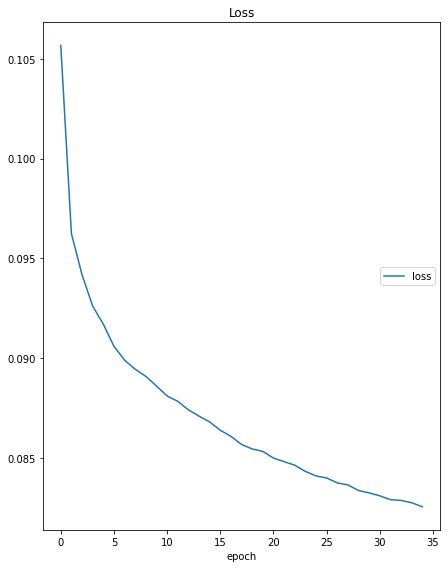

Loss
	loss             	 (min:    0.083, max:    0.106, cur:    0.083)


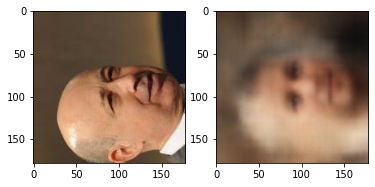

Total Loss:  3.048910123115766


In [13]:

celeba_vae = None # your model (assign it below)

#solution
celeba_vae = VAE(bottleneck_size=1024,channel_size=3).to(device)

# number of epochs
n_epoch = 35
# batch size
batch_size = 8 #power of 2 #If I choose too high, it would not run.
#learning_rate
learning_rate = 0.00005

#Using this to plot loss curves for each epoch live while training
liveloss = PlotLosses()

#Loading the image data using trainloader
trainloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)

#Using the Adam optimizer for the CNN
optimizer = optim.Adam(celeba_vae.parameters(),lr=learning_rate)

total_loss = 0.0
input = None
output = None

for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input = data.to(device)
        
        # initializing gradients
        optimizer.zero_grad()
        
        # Forward pass
        output,mu,std = celeba_vae(input)
        
        #we use weight as a constant to define the relative weights of these two terms
        #we do not want too much weight on the kl divergence otherwise the output will look the same due to converging to one place in the latent space
        #the weight can be very small as we have many training samples which contribute to the latent space being regular
        weight = 1.0/35000
        
        #Calculating loss
        loss = reconstruction_loss(output,input)+(weight*kl_divergence_loss(mu,std))
        
        # Backpropogation
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()/trainloader.__len__()
        total_loss += loss.item()/trainloader.__len__()
        

    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    #Plotting functions:
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    #Plotting the first image in the last batch in each epoch to visualise performance for input vs output
    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(((input.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    imgs[1].imshow(((output.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    plt.show()

print("Total Loss: ", total_loss)


#end_solution


Save model (needed for marking)

In [55]:
torch.save(celeba_vae, 'models/ex4_vae.pth')

NameError: name 'celeba_vae' is not defined

Load pretrained model

# NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [56]:
celeba_vae = torch.load("models/ex4_vae.pth")

Generate and display 10 samples

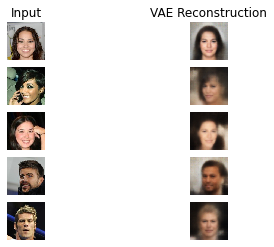

In [57]:
indices = np.random.choice(range(len(celeba_validation_dataset)), 5, replace=False)
celeba_random_images = [celeba_validation_dataset[idx] for idx in indices]


batch = torch.stack(celeba_random_images, dim=0)
gt_img = batch.to(device)

pred_img = celeba_vae(gt_img)[0].permute(0,2,3,1)

imgs_plot = [ el.cpu().squeeze().numpy() for el in gt_img.permute(0,2,3,1)]
pred_plot = [ el.cpu().detach().squeeze().numpy() for el in pred_img]
img = [imgs_plot, pred_plot, ]
titles = ['Input', 'VAE Reconstruction']
plot_images(img, titles, None)
plt.show()
plt.close()

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

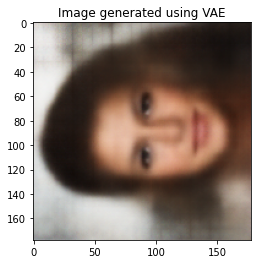

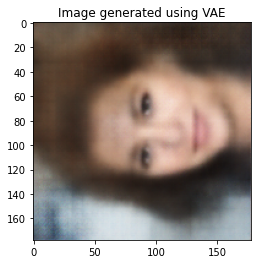

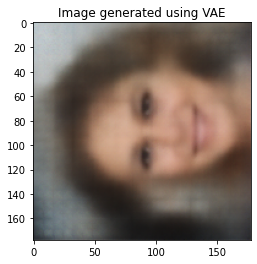

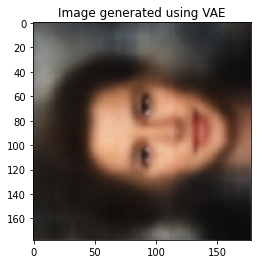

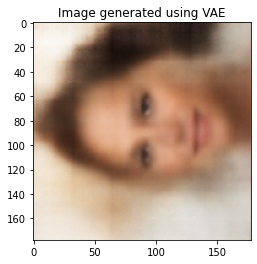

In [60]:
from ast import Num
number_of_samples = 5


#solution

## sampling random latent codes from normal distribution
z = torch.randn((number_of_samples,1024))
##Decoding the random latent code.
decoded_image = celeba_vae.decoder(z.to(device))

for i in range(number_of_samples):
    plt.imshow(((decoded_image.cpu().detach().numpy()[i].T)*255).astype(np.uint8))
    plt.title('Image generated using VAE')
    plt.show()


#end_solution


Save the AE model (needed for marking)

** 4.c**
<a name='4c'></a>

Load the VAE and AE model

# NOTE: PLEASE FIND MY TRAINED MODELS AT THE FOLLOWING GOOGLE DRIVE LINK:
https://drive.google.com/drive/folders/1r3MLqkLhCOL5CDKwJXha9g6ECVOuZ4Qw?usp=sharing

In [61]:
celeba_ae = torch.load('models/ex_3_ae.pth')
celeba_vae = torch.load('models/ex4_vae.pth')

Display samples from both AE and VAE

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

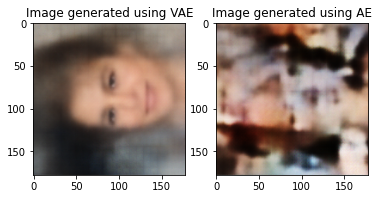

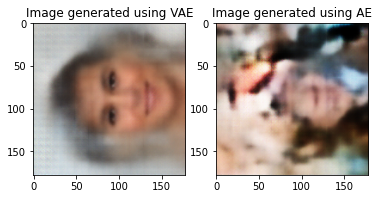

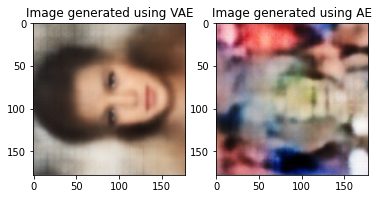

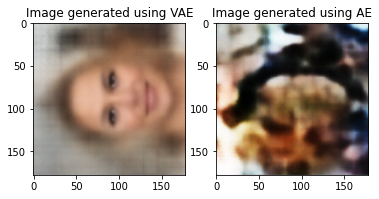

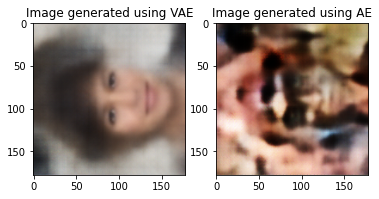

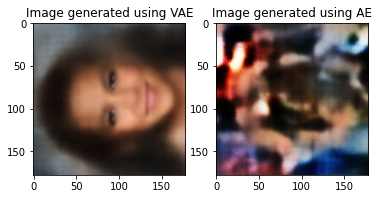

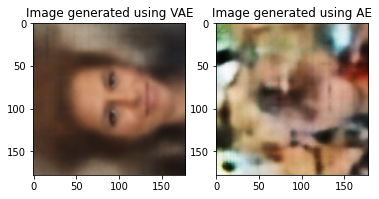

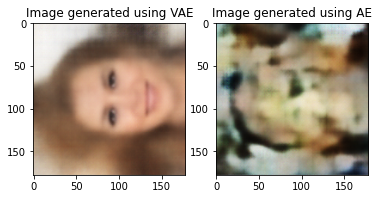

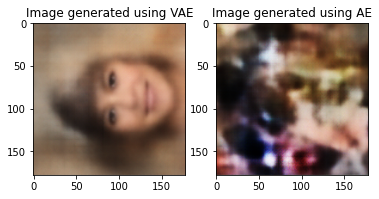

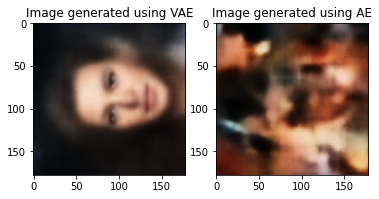

In [62]:
number_of_samples = 10

#solution


#we drop encoder and sample random code to send to decoder
#useing random samples from normal distribution, same as in 4b but with 10 samples instead.
z = torch.randn((number_of_samples,1024))
#Decoding random latent code using both AE and VAE decoders
decoded_image_vae = celeba_vae.decoder(z.to(device))
decoded_image_ae = celeba_ae.decoder(z.to(device))

for i in range(number_of_samples):
    f, imgs = plt.subplots(1,2)
    imgs[0].imshow(((decoded_image_vae.cpu().detach().numpy()[i].T)*255).astype(np.uint8))
    imgs[0].set_title('Image generated using VAE')
    imgs[1].imshow(((decoded_image_ae.cpu().detach().numpy()[i].T)*255).astype(np.uint8))
    imgs[1].set_title('Image generated using AE')
    plt.show()

#end_solution



&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 
As seen above, the images generated using AE do not make sense as they are a combination of randomly coloured pixel pallets, however the VAE provides concistent results which all look like a person, which is because all images sampled from the latent space, represent the face of a person, whereas with the VAE only some areas in the latent space represent a person's face. 

** 4.d**
<a name='4d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 

references:

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

Adam has addaptive moment estimation, and looks at second derivative and does not draw our model to the immediate direction of the gradient. Adam trains faster due to performing gradient clipping and performs automated step size control.
SGD updates our weights based on a function performed on our current weights. This algorithm provides a stable optimisation which is much slower to converge but provides better generalisation and reaches an optimal solution even if it takes much more epochs if we use a small learning rate.

Terms used by Adam and what role they play:
Adam uses terms such as model parameters, learning rate, betas, eps, weight_decay and amsgrad. The model parameters are our weights, the learning rate is used to determine the step size at each itteration to update the weights. betas are decay rates that compute running averages of the gradient and its square to estimate moments. eps is a number which improves the numerical stability of the omptimisation. weight_decay adds a small penaly to the loss which is used to prevent overfitting and keeping our weights small. the amsgrad argument is used to switch to a varient of the algorithm that is based on convergence.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

# TRAINING USING ADAM

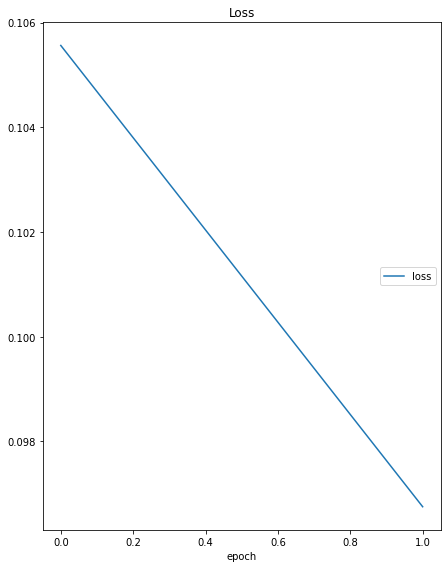

Loss
	loss             	 (min:    0.097, max:    0.106, cur:    0.097)


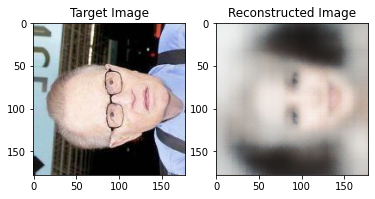

Total Loss:  0.202316888999939


In [30]:
celeba_vae = VAE(bottleneck_size=1024,channel_size=3).to(device)

n_epoch = 2
batch_size = 8
learning_rate = 0.00005

liveloss = PlotLosses()

trainloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)

#optimizer = optim.SGD(celeba_vae.parameters(),lr=learning_rate)
optimizer = optim.Adam(celeba_vae.parameters(),lr=learning_rate)

total_loss = 0.0
input = None
output = None

for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input = data.to(device)
        
        optimizer.zero_grad()
        
        output,mu,std = celeba_vae(input)
        
        weight = 1.0/35000
        
        loss = reconstruction_loss(output,input)+(weight*kl_divergence_loss(mu,std))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()/trainloader.__len__()
        total_loss += loss.item()/trainloader.__len__()
        

    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    
    f, imgs = plt.subplots(1,2)
    imgs[0].set_title('Target Image')
    imgs[0].imshow(((input.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    imgs[1].set_title('Reconstructed Image')
    imgs[1].imshow(((output.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    plt.show()

print("Total Loss: ", total_loss)

##Unassigning model to free up memory
celeba_vae = None


# TRAINING USING SGD

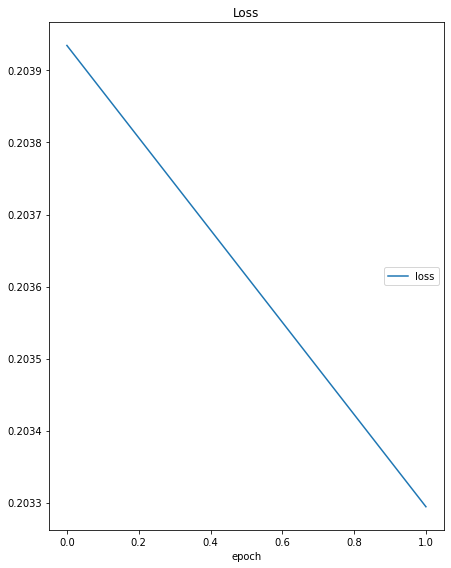

Loss
	loss             	 (min:    0.203, max:    0.204, cur:    0.203)


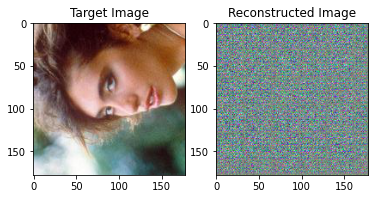

Total Loss:  0.407228955936432


In [31]:
celeba_vae = VAE(bottleneck_size=1024,channel_size=3).to(device)

n_epoch = 2
batch_size = 8
learning_rate = 0.00005

liveloss = PlotLosses()

trainloader = DataLoader(celeba_train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.SGD(celeba_vae.parameters(),lr=learning_rate)
#optimizer = optim.Adam(celeba_vae.parameters(),lr=learning_rate)

total_loss = 0.0
input = None
output = None

for epoch in range(n_epoch):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        input = data.to(device)
        
        optimizer.zero_grad()
        
        output,mu,std = celeba_vae(input)
        
        weight = 1.0/35000
        
        loss = reconstruction_loss(output,input)+(weight*kl_divergence_loss(mu,std))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()/trainloader.__len__()
        total_loss += loss.item()/trainloader.__len__()
        

    print("Epoch: ", epoch+1)
    print("Epoch Loss: ", epoch_loss)
    
    liveloss.update({'loss': epoch_loss})
    liveloss.send()
    
    f, imgs = plt.subplots(1,2)
    imgs[0].set_title('Target Image')
    imgs[0].imshow(((input.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    imgs[1].set_title('Reconstructed Image')
    imgs[1].imshow(((output.cpu().detach().numpy()[0].T)*255).astype(np.uint8))
    plt.show()

print("Total Loss: ", total_loss)

##Unassigning model to free up memory
celeba_vae = None


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 
As we can see in the training in 2 epochs, using both Adam and SGD, we can see that Adam coverges much faster to the solution whereas SGD is much slower with non meaningful reconstructed image after 2 epochs, plus only a tiny reduction in the calculated loss, whereas for Adam, the change in the loss was much bigger. This highighlights the properties of Adam that it converges fater to the solution, however this does not garuntee that the solution will be correct, as we can see the face being converged to does not look quite like the input image and is a generic face.